Optimal x: [-0.78539817]
Minimum value of g(f(x)): 4.999391807814595e-17


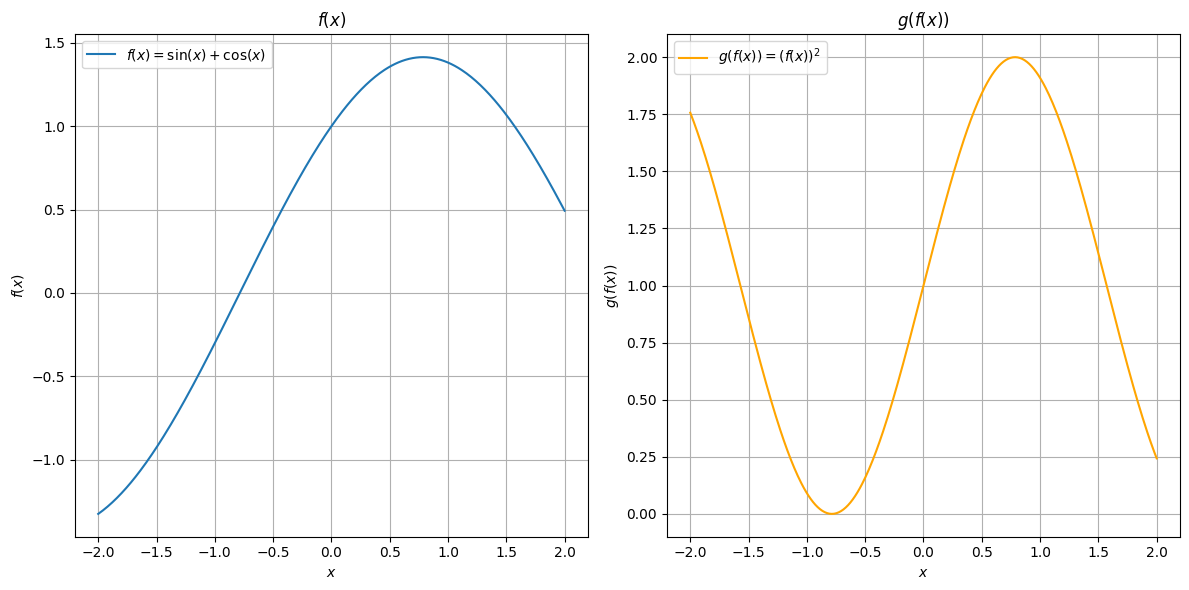

In [2]:
import numpy as np
from scipy.optimize import minimize

# Define the known functions
def f(x):
    return np.sin(x) + np.cos(x)

def g(x):
    return x**2

# Composite function g(f(x))
def composite_function(x):
    return g(f(x))

# Define the bounds for x
bounds = [(-2, 2)]

# Perform the optimization
result = minimize(composite_function, x0=0.0, bounds=bounds)

# Print the result
print("Optimal x:", result.x)
print("Minimum value of g(f(x)):", result.fun)


import numpy as np
import matplotlib.pyplot as plt

# Define the known functions
def f(x):
    return np.sin(x) + np.cos(x)

def g(x):
    return x**2

# Composite function g(f(x))
def composite_function(x):
    return g(f(x))

# Generate data points
x = np.linspace(-2, 2, 400)
y_f = f(x)
y_gf = composite_function(x)

# Plot the functions
plt.figure(figsize=(12, 6))

# Plot f(x)
plt.subplot(1, 2, 1)
plt.plot(x, y_f, label='$f(x) = \sin(x) + \cos(x)$')
plt.title('$f(x)$')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid(True)
plt.legend()

# Plot g(f(x))
plt.subplot(1, 2, 2)
plt.plot(x, y_gf, label='$g(f(x)) = (f(x))^2$', color='orange')
plt.title('$g(f(x))$')
plt.xlabel('$x$')
plt.ylabel('$g(f(x))$')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [1]:
import torch
import gpytorch
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from botorch.acquisition import LogExpectedImprovement
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll

# Define the known functions
def f(x):
    return torch.sin(x) + torch.cos(x)

def g(x):
    return x**2

# Composite function g(f(x))
def composite_function(x):
    return g(f(x))

class CompositeBO:
    def __init__(self, f, g, bounds, initial_points=10):
        self.f = f
        self.g = g
        self.bounds = bounds
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.train_x = torch.linspace(bounds[0], bounds[1], initial_points).unsqueeze(-1).to(self.device, dtype=torch.double)
        self.train_y = self.evaluate_objective(self.train_x)
        self.model = self.fit_model(self.train_x, self.train_y)

    def evaluate_objective(self, x):
        with torch.no_grad():
            return self.g(self.f(x))

    def fit_model(self, x, y):
        gp = SingleTaskGP(x, y)
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
        mll = mll.to(x)
        fit_gpytorch_mll(mll)
        return gp

    def optimize_acquisition(self):
        EI = LogExpectedImprovement(model=self.model, best_f=self.train_y.min())
        bounds_tensor = torch.tensor([self.bounds], dtype=torch.double).T.to(self.device)
        candidate, _ = optimize_acqf(
            acq_function=EI,
            bounds=bounds_tensor,
            q=1,
            num_restarts=5,
            raw_samples=20,
        )
        return candidate

    def update(self):
        new_x = self.optimize_acquisition()
        new_y = self.evaluate_objective(new_x)
        self.train_x = torch.cat([self.train_x, new_x])
        self.train_y = torch.cat([self.train_y, new_y])
        self.model = self.fit_model(self.train_x, self.train_y)

    def run_optimization(self, iterations=10):
        for _ in range(iterations):
            self.update()

# Define the optimization bounds
bounds = [-2.0, 2.0]

# Create an instance of the CompositeBO class
composite_bo = CompositeBO(f=f, g=g, bounds=bounds)

# Run the optimization for a specified number of iterations
composite_bo.run_optimization(iterations=50)

# Print the optimal value found
print("Optimal x:", composite_bo.train_x[composite_bo.train_y.argmin()])
print("Minimum value of g(f(x)):", composite_bo.train_y.min().item())

/home/onoue/ws/Hackathon_vol.10/dp-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/onoue/ws/Hackathon_vol.10/dp-env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/home/onoue/ws/Hackathon_vol.10/dp-env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.7204], dtype=torch.float64), mean = tensor([1.], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)
/home/onoue/ws/Hackathon_vol.10/dp-env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataW

Optimal x: tensor([-0.6667], dtype=torch.float64)
Minimum value of g(f(x)): 0.028062117331692928


/home/onoue/ws/Hackathon_vol.10/dp-env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:257: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  check_min_max_scaling(
/home/onoue/ws/Hackathon_vol.10/dp-env/lib/python3.10/site-packages/botorch/models/utils/assorted.py:260: InputDataWarning: Data is not standardized (std = tensor([0.4695], dtype=torch.float64), mean = tensor([1.8333], dtype=torch.float64)). Please consider scaling the input to zero mean and unit variance.
  check_standardization(Y=train_Y, raise_on_fail=raise_on_fail)


In [3]:
# Print the optimal value found
print("Optimal x:", composite_bo.train_x[composite_bo.train_y.argmin()])
print("Minimum value of g(f(x)):", composite_bo.train_y.min().item())

Optimal x: tensor([-0.6667], dtype=torch.float64)
Minimum value of g(f(x)): 0.028062117331692928
